# **Duplicate Questions with the Quora Dataset**

This notebook demonstrates the implementation of a text classification model using a Transformer network to detect similar questions. Its purpose is to determine whether two questions are paraphrases of each other using the [Quora Question Pairs dataset](https://huggingface.co/datasets/nyu-mll/glue/viewer/qqp/test). For this task, the pre-trained [BERT (Pre-training of Deep Bidirectional Transformers for Language Understanding)](https://huggingface.co/docs/transformers/model_doc/bert) model from [Hugging Face 🤗](https://huggingface.co/) is fine-tuned to improve its performance in the specific task of detecting duplicate questions. Hugging Face is a platform focused on developing tools and models for natural language processing (NLP). It is known for its open-source library called Transformers, which provides an easy-to-use interface for working with advanced, pre-trained NLP models like BERT, T5, GPT, and others.

**Key Points:**
- **Model Architecture:** The Hugging Face BERT Large model is used, a bidirectional transformer pre-trained using a combination of masked language modeling and next sentence prediction objectives on a large corpus comprising the Toronto Book Corpus and Wikipedia. This model has achieved state-of-the-art results in multiple natural language processing tasks, evaluated on datasets like GLUE, MultiNLI, and SQuAD. The model is loaded using the generic class [TFAutoModelForSequenceClassification](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodelforsequenceclassification), which allows creating an instance of a pre-trained TensorFlow-based model designed specifically for sequence classification tasks as it includes a classification layer on top. This differentiates it from [TFAutoModel](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel), which provides the base model without additional layers.

- **Tokenization:** Hugging Face has already implemented a tokenizer for each of its models that returns everything necessary for the respective model inputs. For this case, the generic tokenizer [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) will be used, which allows instantiating the model's tokenizer with just its name. For this duplicate question task, the pair of questions is passed as input to the tokenizer, which returns `input_ids` (the tokenized questions separated by the special `[SEP]` token to differentiate both sequences) and `attention_mask` (a mask to avoid paying attention to the padding token indices).

- **Using a TPU:** Due to the enormous size of the BERT model, specifically ``bert-large-uncased``, which has over 300 million parameters, using a TPU in Google Colab is required to significantly accelerate the training. Although only the parameters of the classification layer are fine-tuned, loading and processing pre-trained embeddings, along with intensive backpropagation calculations, require considerable computational resources. The TPU facilitates efficient handling of these tasks compared to GPUs or CPUs, optimizing performance and training time.

- **Comparison with the [Bidirectional LSTM Siamese Network Model](https://github.com/JersonGB22/TextClassification-TensorFlow/blob/main/models_lstm/DuplicateQuestions_LSTM_Quora.ipynb):** In this notebook, the results obtained with the Transformer network using the BERT model will be compared with the results obtained from the LSTM network model.

In [ ]:
!pip install datasets -q

In [2]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML

### **Parameters**

In [3]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
epochs = 10
batch_size = 64
buffer_size = 1024
max_length = 256
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

model_name = "bert-large-uncased"
train_filename = "/content/drive/MyDrive/Datasets/train_quora_bert.tfrecord"
val_filename = "/content/drive/MyDrive/Datasets/val_quora_bert.tfrecord"
test_filename = "/content/drive/MyDrive/Datasets/test_quora_bert.tfrecord"

### **Preprocessing and Saving Data in TFRecord Format**

Since the Quora dataset is large and the BERT Large model is also substantial, the data is preprocessed, tokenized, and saved in TFRecord format, which allows for truly massive data pipeline performance for training on Colab's TPU. This is now more accessible as it is no longer necessary to store the TFRecord files in Google Cloud Storage due to the new version of Colab's TPU, ``TPU v2``, which has [transitioned from TPU Node to TPU VM](https://github.com/googlecolab/colabtools/issues/4481).

In [ ]:
# Load the dataset from the Hugging Face's 'datasets' library
df = load_dataset("quora")["train"].to_pandas()

# Extract question pairs without considering empty strings
df["question_1"] = df.questions.apply(lambda x: x["text"][0] if len(x["text"][0]) > 0 else None)
df["question_2"] = df.questions.apply(lambda x: x["text"][1] if len(x["text"][1]) > 0 else None)

# Remove the 'questions' column
df = df.drop(columns=["questions"])

# Remove missing records
df = df.dropna().reset_index(drop=True)

# Change the data type of the 'is_duplicate' column
df["is_duplicate"] = df.is_duplicate.astype(np.int32)

df

,is_duplicate,question_1,question_2
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,0,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?
...,...,...,...
404283,0,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...
404284,1,Do you believe there is life after death?,Is it true that there is life after death?
404285,0,What is one coin?,What's this coin?
404286,0,What is the approx annual cost of living while...,I am having little hairfall problem but I want...


In [ ]:
print(df.info(), "\n")
df[df.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404288 entries, 0 to 404287
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   is_duplicate  404288 non-null  int32 
 1   question_1    404288 non-null  object
 2   question_2    404288 non-null  object
dtypes: int32(1), object(2)
memory usage: 7.7+ MB
None 



,is_duplicate,question_1,question_2


**Undersampling**

Since the dataset is unbalanced and non-duplicate questions are predominant, it's necessary to perform undersampling to have an equal amount of duplicate and non-duplicate questions, thus improving the training process.

In [ ]:
print(df.is_duplicate.value_counts(), "\n")
min_size = df.is_duplicate.value_counts().min()
min_size

is_duplicate
0    255025
1    149263
Name: count, dtype: int64 



149263

In [ ]:
df_minority = df[df.is_duplicate == 1]
df_majority = df[df.is_duplicate == 0]
df_majority = df_majority.sample(min_size, random_state=SEED)
df = pd.concat([df_majority, df_minority], axis=0)

del df_minority, df_majority

df.is_duplicate.value_counts()

is_duplicate
0    149263
1    149263
Name: count, dtype: int64

**Splitting the dataframe into training (90%), validation (5%) y testing (5%) sets**

In [ ]:
df_train, df_val_test = train_test_split(df, test_size=0.1, random_state=SEED, stratify=df.is_duplicate)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=SEED, stratify=df_val_test.is_duplicate)

del df, df_val_test #Remove to free memory

print(len(df_train), len(df_val), len(df_test), "\n")

# Thanks to the 'stratify' argument, the distribution is preserved
print(df_train.is_duplicate.value_counts())
print(df_val.is_duplicate.value_counts())
print(df_test.is_duplicate.value_counts())

268673 14926 14927 

is_duplicate
1    134337
0    134336
Name: count, dtype: int64
is_duplicate
1    7463
0    7463
Name: count, dtype: int64
is_duplicate
0    7464
1    7463
Name: count, dtype: int64


In [ ]:
df_test.to_csv("/content/drive/MyDrive/Datasets/test_dataset_quora.csv", index=False)

**Import the AutoTokenizer**

In [6]:
# 'use_fast=True': improves the tokenizer's performance when processing large volumes of text

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer

BertTokenizerFast(name_or_path='bert-large-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
# Example of tokenization

q1 = df_train.question_1[1]
q2 = df_train.question_2[1]
print(q1, "\t", q2)
encoding = tokenizer(
    q1,
    q2,
    padding="max_length",
    truncation=True,
    max_length=50,
    return_tensors="tf" #Returns the results in TensorFlow tensor format
)

print(encoding["input_ids"].numpy()[0])
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"][0]))
print(tokenizer.decode(encoding["input_ids"][0]), "\n")

print(encoding["attention_mask"].numpy()[0])

What is the story of Kohinoor (Koh-i-Noor) Diamond? 	 What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?
[  101  2054  2003  1996  2466  1997 12849 10606 16506  1006 12849  2232
  1011  1045  1011  2053  2953  1007  6323  1029   102  2054  2052  4148
  2065  1996  2796  2231 10312  1996 12849 10606 16506  1006 12849  2232
  1011  1045  1011  2053  2953  1007  6323  2067  1029   102     0     0
     0     0]
['[CLS]', 'what', 'is', 'the', 'story', 'of', 'ko', '##hin', '##oor', '(', 'ko', '##h', '-', 'i', '-', 'no', '##or', ')', 'diamond', '?', '[SEP]', 'what', 'would', 'happen', 'if', 'the', 'indian', 'government', 'stole', 'the', 'ko', '##hin', '##oor', '(', 'ko', '##h', '-', 'i', '-', 'no', '##or', ')', 'diamond', 'back', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[CLS] what is the story of kohinoor ( koh - i - noor ) diamond? [SEP] what would happen if the indian government stole the kohinoor ( koh - i - noor ) diamond back? [SEP] [PAD] [P

The number of tokenized question pairs in the training set that exceed the length of 256 tokens is only 7, so it is sufficient in this case for the `max_length` to be 256.

```
li = []
for _, row in df_train.iterrows():
  li.append(len(tokenizer(row["question_1"], row["question_2"], truncation=True)["input_ids"]))

print(len([x for x in li if x > 256]))
# Output: 7
```

In [7]:
# Tokenization function

def preprocessing(question_1, question_2, return_tensors=None):
  encoding = tokenizer(
      question_1,
      question_2,
      padding="max_length",
      truncation=True,
      max_length=max_length,
      return_tensors=return_tensors
  )

  return encoding["input_ids"], encoding["attention_mask"]

**Saving Data in TFRecord Format**

In [ ]:
def save_tfrecord(filename, df):
  with tf.io.TFRecordWriter(filename) as writer:
    for _, row in df.iterrows():
      input_ids, attention_mask = preprocessing(row["question_1"], row["question_2"])

      features = {
          "input_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),
          "attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(value=attention_mask)),
          "labels": tf.train.Feature(int64_list=tf.train.Int64List(value=[row["is_duplicate"]]))
      }

      features = tf.train.Features(feature=features)
      example = tf.train.Example(features=features).SerializeToString()
      writer.write(example)

In [ ]:
save_tfrecord(train_filename, df_train)
save_tfrecord(val_filename, df_val)
save_tfrecord(test_filename, df_test)

### **Using the TPU for Training**

From here onwards until 'Predictions with the trained model', it is mandatory to use the TPU, as even with the TPU, each epoch takes approximately 22 minutes to complete.

In [5]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except ValueError:
  print("TPU not found")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


**Loading the Preprocessed Datasets**

In [6]:
train_size, val_size, test_size = 268673, 14926, 14927

In [7]:
def decode_tfrecord(sample):
  features = {
      "input_ids": tf.io.FixedLenFeature((max_length, ), tf.int64),
      "attention_mask": tf.io.FixedLenFeature((max_length, ), tf.int64),
      "labels": tf.io.FixedLenFeature((), tf.int64),
  }

  parsed_features = tf.io.parse_example(sample, features)
  input_ids = parsed_features["input_ids"]
  attention_mask = parsed_features["attention_mask"]
  labels = parsed_features["labels"]

  return (input_ids, attention_mask), labels


def load_dataset(filename, size):
  dataset = tf.data.TFRecordDataset(filename)
  dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
  dataset = dataset.apply(tf.data.experimental.assert_cardinality(size))
  return dataset

In [8]:
train_dataset = load_dataset(train_filename, train_size)
val_dataset = load_dataset(val_filename, val_size)
test_dataset = load_dataset(test_filename, test_size)

train_dataset = train_dataset.shuffle(buffer_size, seed=SEED).batch(batch_size).prefetch(AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

In [9]:
# Viewing a training batch
for (ids, masks), labels in train_dataset.take(1):
  print(ids, "\n")
  print(masks, "\n")
  print(labels)

tf.Tensor(
[[ 101 2003 4241 ...    0    0    0]
 [ 101 2339 2134 ...    0    0    0]
 [ 101 2129 2515 ...    0    0    0]
 ...
 [ 101 2339 2064 ...    0    0    0]
 [ 101 2129 2024 ...    0    0    0]
 [ 101 2054 2003 ...    0    0    0]], shape=(64, 256), dtype=int64) 

tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(64, 256), dtype=int64) 

tf.Tensor(
[1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1
 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0], shape=(64,), dtype=int64)


**Build the Model**


In [10]:
# Callback to stop training early if validation accuracy does not improve for 2 epochs.
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy",
    patience=2,
    mode="max",
    restore_best_weights=True
)

In [11]:
def create_model():
  # Import the AutoModel
  model_base = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

  input_ids = tf.keras.Input((max_length, ), dtype=tf.int32)
  attention_mask = tf.keras.Input((max_length, ), dtype=tf.int32)
  x = model_base(input_ids=input_ids, attention_mask=attention_mask).logits

  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=x)

  return model

In [12]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

# Creation and compilation of the model within the distribution strategy
with strategy.scope():
  model = create_model()

  model.compile(
      optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=0.01),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=["sparse_categorical_accuracy"],
      steps_per_execution=400
  )

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   3351439   ['input_1[0][0]',             
 ification (TFBertForSequen  (loss=None, logits=(None,    38         'input_2[0][0]']             
 ceClassification)           2),                                                                  
                              hidden_states=None, atten                                       

In [14]:
tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])

Epoch 1/10
4199/4199 [==============================] - 1655s 394ms/step - loss: 0.3161 - sparse_categorical_accuracy: 0.8619 - val_loss: 0.2542 - val_sparse_categorical_accuracy: 0.8935
Epoch 2/10
4199/4199 [==============================] - 1283s 306ms/step - loss: 0.2031 - sparse_categorical_accuracy: 0.9195 - val_loss: 0.2570 - val_sparse_categorical_accuracy: 0.9021
Epoch 3/10
4199/4199 [==============================] - 1283s 306ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.2916 - val_sparse_categorical_accuracy: 0.9045
Epoch 4/10
4199/4199 [==============================] - 1283s 306ms/step - loss: 0.0843 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.3528 - val_sparse_categorical_accuracy: 0.9089
Epoch 5/10
4199/4199 [==============================] - 1282s 305ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.4000 - val_sparse_categorical_accuracy: 0.9030
Epoch 6/10
4199/4199 [==============================] - 1297s 309

**Save model**

In [9]:
trained_model_path = "/content/drive/MyDrive/models/DuplicateQuestions_BERT_Quora"

In [17]:
model.layers[2].save_pretrained(trained_model_path)

### **Model Evaluation**

In [18]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(val_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.03811207413673401, 0.9874568581581116]
[0.3527679145336151, 0.908883810043335]
[0.3309125602245331, 0.911837637424469]


The model achieves an accuracy of **98.7%** on the training dataset in just 4 epochs. Meanwhile, it reaches **90.9%** on the validation dataset and **91.2%** on the testing dataset. This demonstrates the significant superiority of the Transformer model over the bidirectional LSTM siamese network, which only achieved an accuracy of **83.6%** on the testing dataset. Although there is a notable reduction in overfitting, the model still exhibits some signs of overfitting. This could be mitigated by increasing the size of the training set or selecting a pre-trained model from Hugging Face that achieves better results in this task. However, to do this, a computing capacity superior to the free TPU provided by Colab is required.

In [20]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [21]:
plot_metrics(metric="sparse_categorical_accuracy")
plot_metrics()

**Images for GitHub**

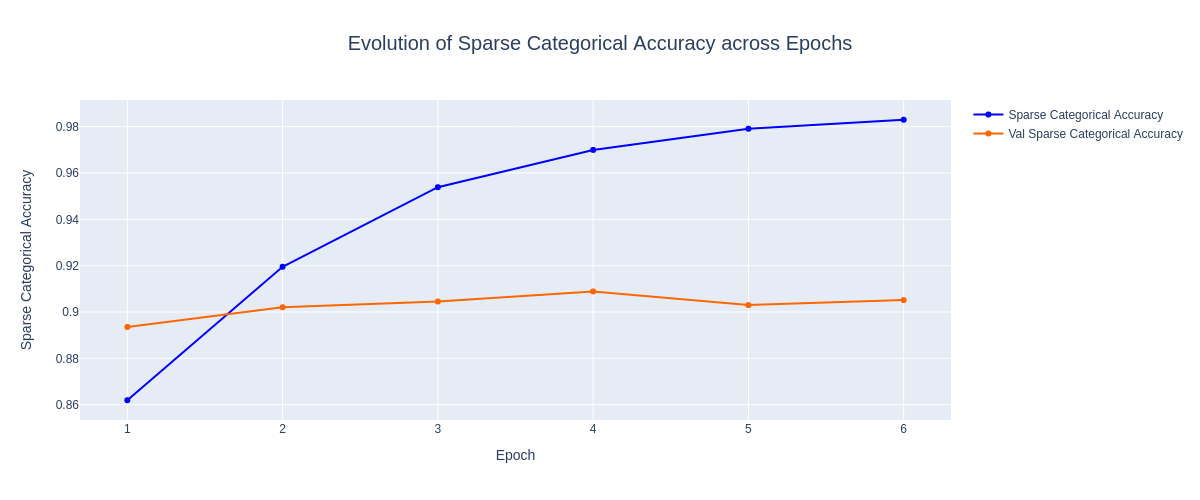

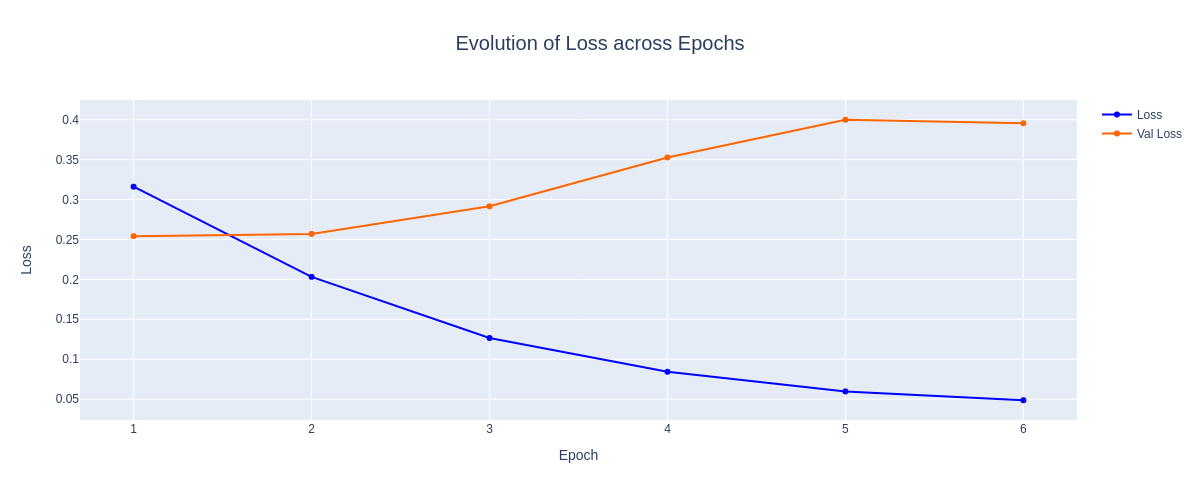

In [22]:
plot_metrics(renderer="png", metric="sparse_categorical_accuracy")
plot_metrics(renderer="png")

**Confusion Matrix**

Accuracy: 0.9118376097005426
F1 Score: 0.9140431090790334
Total not duplicates:  7464 ; Total duplicates:  7463
[11.38799571  6.24413775]


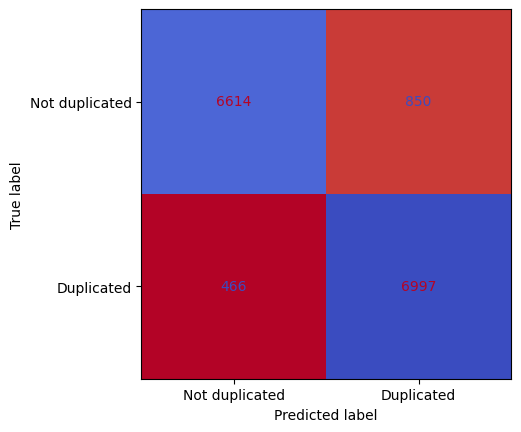

In [23]:
labels_test = test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels_test = np.array(list(labels_test))

labels_test_pred = model.predict(test_dataset, verbose=0)
labels_test_pred = np.argmax(labels_test_pred, axis=-1)
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred)}")

cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Not duplicated", "Duplicated"])
cmd.plot(colorbar=False, cmap="coolwarm_r");

print("Total not duplicates: ", np.bincount(labels_test)[0], "; Total duplicates: ", np.bincount(labels_test)[1])
print(((np.bincount(labels_test) - np.diag(cm)) / np.bincount(labels_test)) * 100)

It is evident that the model faces a greater difficulty in correctly classifying non-duplicate questions, as reflected in a higher percentage of false positives (11.4%) compared to false negatives (6.2%). However, compared to the LSTM network, it has significantly improved. This is because the model is quite capable of detecting the complex relationships necessary to correctly classify whether two questions are paraphrases of each other, much like how humans would, thanks to BERT pretraining.

### **Predictions with the trained model**

In [11]:
# Load the trained model and the testing dataframe

model = TFAutoModelForSequenceClassification.from_pretrained(trained_model_path, num_labels=2)
df_test = pd.read_csv("/content/drive/MyDrive/Datasets/test_dataset_quora.csv")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/models/DuplicateQuestions_BERT_Quora.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [88]:
def predict_duplicate(questions_1, questions_2, labels, random=True, indice=0):
  label_names = ["Non-Duplicate Question", "Duplicate Question"]
  label_colors = ["green", "red"]

  indice = np.random.choice(len(questions_1)) if random else indice
  q1 = questions_1[indice]
  q2 = questions_2[indice]
  input_ids, attention_mask = preprocessing(q1, q2, return_tensors="tf")

  label_pred = model(input_ids, attention_mask).logits.numpy()
  label_pred = np.argmax(label_pred, axis=-1)[0]

  html_content = f"""
    <b>Question 1:</b> {q1}<br><br>
    <b>Question 2:</b> {q2}<br><br>
    <b>True Label: <span style="color: {label_colors[labels[indice]]}">{label_names[labels[indice]]}</span></b><br>
    <b>Predicted Label: <span style="color: {label_colors[label_pred]}">{label_names[label_pred]}</span></b>
    """
  display(HTML(html_content))

#### **Test Dataset**

In [13]:
questions_1, questions_2 = df_test.question_1.values, df_test.question_2.values
labels = df_test.is_duplicate.values

In [14]:
predict_duplicate(questions_1, questions_2, labels, random=False)

In [31]:
predict_duplicate(questions_1, questions_2, labels)

In [34]:
# Long Questions
predict_duplicate(questions_1, questions_2, labels)

In [95]:
# Long Questions
predict_duplicate(questions_1, questions_2, labels, random=False, indice=1392)

In [66]:
# Long Questions
predict_duplicate(questions_1, questions_2, labels)

In [96]:
# Long Questions
predict_duplicate(questions_1, questions_2, labels, random=False, indice=2358)

In [98]:
# Correct Prediction!!!
predict_duplicate(questions_1, questions_2, labels, random=False, indice=13086)

#### **Other Questions**

In [92]:
q1 = ["How can I lose weight fast?"]
q2 = ["What are some effective weight loss strategies?"]
label = [1]

predict_duplicate(q1, q2, label)

In [18]:
q1 = ["What is the difference between a quadratic equation and a cubic equation?"]
q2 = ["How do you solve a cubic equation?"]
label = [0]

predict_duplicate(q1, q2, label)

In [19]:
# More challenging questions
q1 = ["What are the most effective methods for reducing carbon emissions in urban areas to combat climate change?"]
q2 = ["How can cities reduce carbon emissions to mitigate the impacts of climate change?"]
label = [1]

predict_duplicate(q1, q2, label)

In [20]:
# More challenging questions
q1 = ["What are the key differences between traditional Chinese medicine and modern Western medicine?"]
q2 = ["How do Eastern and Western medical practices differ in their approaches to healthcare?"]
label = [0]

predict_duplicate(q1, q2, label)

**Conclusion:** The model demonstrates accurate predictions not only within the test set but also when presented with other pairs of complex and/or lengthy questions that are not part of the Quora dataset. Additionally, it accurately predicts questions that require a deep understanding of context, a task where the LSTM network fails. This is due to the model's multiple layers of attention, which can capture complex relationships within sentences.